**Install dependencies**

In [ ]:
!pip install torch torchvision matplotlib tqdm


In [ ]:
!wget https://archive.org/download/UTKFace/UTKFace.tar.gz
!mkdir -p utkface && tar -xvzf UTKFace.tar.gz -C utkface


Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

**Process the dataset**

In [ ]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        age = int(img_name.split('_')[0])  # Extract age label from filename
        age_class = min(age // 10, 5)      # Bin ages into 6 groups (0-9, ..., 50+)

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(age_class, dtype=torch.long)
        return image, label

dataset = UTKFaceDataset("utkface/UTKFace", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


**Define Generator and Discriminator**

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=6, img_channels=3):
        super().__init__()
        self.label_embed = nn.Embedding(label_dim, label_dim)
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 512 * 4 * 4),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1),  # 128x128
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_embed(labels)
        x = torch.cat([noise, label_embed], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 512, 4, 4)
        img = self.deconv(x)
        return img

class Discriminator(nn.Module):
    def __init__(self, label_dim=6, img_channels=3):
        super().__init__()
        self.label_dim = label_dim
        self.img_channels = img_channels

        # Conv2D expects image + label channels
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, 64, 4, stride=2, padding=1),  # 4 channels in
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, stride=2, padding=0),
        )

    def forward(self, img, labels):
        # Create label map the same height and width as image
        batch_size, _, h, w = img.shape
        label_map = labels.unsqueeze(1).unsqueeze(2).unsqueeze(3)  # [B, 1, 1, 1]
        label_map = label_map.repeat(1, 1, h, w).float()  # [B, 1, H, W]

        # Combine image and label map along channels
        d_in = torch.cat([img, label_map], dim=1)  # [B, 4, H, W]
        return self.model(d_in).view(-1)



**WGAN-GP Loss Functions**

In [ ]:
def gradient_penalty(D, real, fake, labels, device):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


**Training Loop with Visualization + Checkpoint**


In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)
D = Discriminator().to(device)

optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

fixed_noise = torch.randn(6, 100, device=device)
fixed_labels = torch.tensor(list(range(6)), device=device)

def save_samples(generator, step):
    with torch.no_grad():
        samples = generator(fixed_noise, fixed_labels).cpu()
        grid = (samples + 1) / 2  # unnormalize
        fig, axes = plt.subpalots(1, 6, figsize=(12, 2))
        for img, ax in zip(grid, axes):
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis("off")
        plt.savefig(f"generated_epoch_{step}.png")
        plt.close()

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, 101):
    for i, (real_imgs, labels) in enumerate(tqdm(dataloader)):
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        # --- Train Discriminator ---
        noise = torch.randn(real_imgs.size(0), 100, device=device)
        fake_imgs = G(noise, labels).detach()
        real_validity = D(real_imgs, labels)
        fake_validity = D(fake_imgs, labels)
        gp = gradient_penalty(D, real_imgs, fake_imgs, labels, device)

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + 10 * gp
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        if i % 5 == 0:
            noise = torch.randn(real_imgs.size(0), 100, device=device)
            gen_imgs = G(noise, labels)
            g_loss = -torch.mean(D(gen_imgs, labels))

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    print(f"[Epoch {epoch}] D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    save_samples(G, epoch)
    torch.save(G.state_dict(), f"checkpoints/generator_epoch_{epoch}.pth")


100%|██████████| 371/371 [01:36<00:00,  3.86it/s]


[Epoch 1] D Loss: -0.8849 | G Loss: 1.4913


100%|██████████| 371/371 [01:38<00:00,  3.77it/s]


[Epoch 2] D Loss: -0.3714 | G Loss: 2.2941


100%|██████████| 371/371 [01:39<00:00,  3.72it/s]


[Epoch 3] D Loss: -0.4846 | G Loss: 3.1363


100%|██████████| 371/371 [01:40<00:00,  3.70it/s]


[Epoch 4] D Loss: -0.2677 | G Loss: 3.7828


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 5] D Loss: -0.2493 | G Loss: 4.0052


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 6] D Loss: -0.2721 | G Loss: 4.1287


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 7] D Loss: -0.1939 | G Loss: 4.2956


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 8] D Loss: -0.1916 | G Loss: 4.4616


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 9] D Loss: -0.1166 | G Loss: 4.8056


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 10] D Loss: -0.1239 | G Loss: 5.0704


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 11] D Loss: -0.1075 | G Loss: 5.2700


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 12] D Loss: -0.1466 | G Loss: 5.3015


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 13] D Loss: -0.2047 | G Loss: 5.3797


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 14] D Loss: -0.0840 | G Loss: 5.5178


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 15] D Loss: -0.1765 | G Loss: 5.3900


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 16] D Loss: -0.0709 | G Loss: 5.4562


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 17] D Loss: -0.0368 | G Loss: 5.5078


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 18] D Loss: -0.0957 | G Loss: 5.7063


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 19] D Loss: -0.0880 | G Loss: 5.5498


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 20] D Loss: -0.0612 | G Loss: 5.6694


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 21] D Loss: -0.0800 | G Loss: 5.9515


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 22] D Loss: -0.0658 | G Loss: 5.7650


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 23] D Loss: -0.0786 | G Loss: 5.6449


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 24] D Loss: -0.0112 | G Loss: 5.8819


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 25] D Loss: -0.1259 | G Loss: 5.9675


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 26] D Loss: -0.0924 | G Loss: 5.7203


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 27] D Loss: -0.0637 | G Loss: 5.7925


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 28] D Loss: -0.0772 | G Loss: 5.9562


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 29] D Loss: -0.0992 | G Loss: 5.6976


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 30] D Loss: -0.0801 | G Loss: 5.8813


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 31] D Loss: -0.1228 | G Loss: 5.7060


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 32] D Loss: -0.0917 | G Loss: 5.7579


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 33] D Loss: -0.0911 | G Loss: 5.7417


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 34] D Loss: -0.0593 | G Loss: 5.8151


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 35] D Loss: -0.0399 | G Loss: 5.6848


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 36] D Loss: 0.2414 | G Loss: 5.6888


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 37] D Loss: -0.0844 | G Loss: 5.7751


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 38] D Loss: -0.0576 | G Loss: 5.6722


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 39] D Loss: -0.0197 | G Loss: 5.7576


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 40] D Loss: -0.0392 | G Loss: 5.8443


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 41] D Loss: -0.0295 | G Loss: 5.5314


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 42] D Loss: -0.0439 | G Loss: 5.6935


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 43] D Loss: -0.0527 | G Loss: 5.6140


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 44] D Loss: -0.0568 | G Loss: 5.8696


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 45] D Loss: 0.0060 | G Loss: 5.8805


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 46] D Loss: -0.0041 | G Loss: 5.5124


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 47] D Loss: -0.0589 | G Loss: 5.8531


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 48] D Loss: -0.0573 | G Loss: 5.7745


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 49] D Loss: -0.0739 | G Loss: 5.8112


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 50] D Loss: -0.0759 | G Loss: 5.9664


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 51] D Loss: -0.0926 | G Loss: 5.3741


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 52] D Loss: -0.0648 | G Loss: 5.6938


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 53] D Loss: -0.0472 | G Loss: 5.8754


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 54] D Loss: 0.0516 | G Loss: 5.7375


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 55] D Loss: -0.0392 | G Loss: 6.1529


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 56] D Loss: -0.1046 | G Loss: 6.0707


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 57] D Loss: -0.0416 | G Loss: 5.9275


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 58] D Loss: 0.1411 | G Loss: 5.8396


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 59] D Loss: 0.2078 | G Loss: 6.0123


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 60] D Loss: 0.0114 | G Loss: 6.4349


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 61] D Loss: -0.0112 | G Loss: 6.1211


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 62] D Loss: -0.0917 | G Loss: 6.2231


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 63] D Loss: -0.0631 | G Loss: 6.1015


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 64] D Loss: 0.1031 | G Loss: 6.1966


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 65] D Loss: -0.0591 | G Loss: 6.4650


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 66] D Loss: -0.0317 | G Loss: 6.3168


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 67] D Loss: -0.0604 | G Loss: 6.5715


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 68] D Loss: -0.0866 | G Loss: 6.2080


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 69] D Loss: -0.0474 | G Loss: 6.5853


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 70] D Loss: -0.0152 | G Loss: 6.3796


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 71] D Loss: -0.0389 | G Loss: 6.5472


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 72] D Loss: -0.0136 | G Loss: 6.3464


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 73] D Loss: 0.0008 | G Loss: 6.6141


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 74] D Loss: -0.0541 | G Loss: 6.5690


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 75] D Loss: -0.0191 | G Loss: 6.5406


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 76] D Loss: -0.0828 | G Loss: 7.0268


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 77] D Loss: 0.0161 | G Loss: 6.5715


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 78] D Loss: -0.0324 | G Loss: 6.4487


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 79] D Loss: -0.0399 | G Loss: 6.9194


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 80] D Loss: 0.0299 | G Loss: 6.7100


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 81] D Loss: 0.0074 | G Loss: 6.7186


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 82] D Loss: 0.0045 | G Loss: 6.7885


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 83] D Loss: -0.0287 | G Loss: 6.5000


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 84] D Loss: -0.0295 | G Loss: 6.8501


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 85] D Loss: -0.0238 | G Loss: 6.4847


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 86] D Loss: -0.0238 | G Loss: 6.7275


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 87] D Loss: -0.0252 | G Loss: 6.7545


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 88] D Loss: 0.0546 | G Loss: 6.9511


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 89] D Loss: 0.0020 | G Loss: 6.5680


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 90] D Loss: -0.0081 | G Loss: 6.9294


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 91] D Loss: -0.0484 | G Loss: 6.7143


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 92] D Loss: -0.0170 | G Loss: 6.7407


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 93] D Loss: -0.0165 | G Loss: 6.8028


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 94] D Loss: -0.0798 | G Loss: 7.2357


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 95] D Loss: -0.0218 | G Loss: 6.8308


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 96] D Loss: 0.0679 | G Loss: 7.0771


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 97] D Loss: -0.0010 | G Loss: 7.1510


100%|██████████| 371/371 [01:40<00:00,  3.68it/s]


[Epoch 98] D Loss: -0.0051 | G Loss: 6.7109


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 99] D Loss: -0.0498 | G Loss: 7.0740


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


[Epoch 100] D Loss: -0.0234 | G Loss: 7.0298


**Generate New Images After Training**

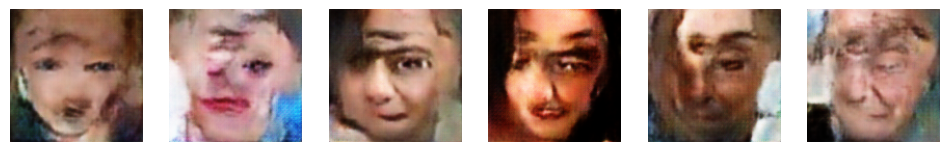

In [ ]:
G.load_state_dict(torch.load("checkpoints/generator_epoch_100.pth"))
G.eval()

noise = torch.randn(6, 100, device=device)
labels = torch.tensor([0, 1, 2, 3, 4, 5], device=device)

with torch.no_grad():
    imgs = G(noise, labels).cpu()
    imgs = (imgs + 1) / 2  # unnormalize
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axes[i].imshow(imgs[i].permute(1, 2, 0))
        axes[i].axis('off')
    plt.show()
